In [22]:
from dotenv import load_dotenv

load_dotenv()
from typing_extensions import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [23]:
from langchain.chat_models import init_chat_model

In [30]:
llm = init_chat_model("google_genai:gemini-2.0-flash")

class State(TypedDict):
    message: Annotated[list, add_messages]

def chatbot(state: State) -> State:
    return {"message": [llm.invoke(state["message"])]}

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)

builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)

graph = builder.compile()

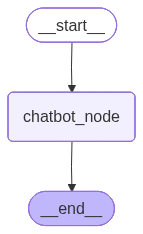

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
message = {"role": "user", "content": "Who walked on the moon for the first time? Print only the name"}
response = graph.invoke({"message":[message]})

response["message"]

[HumanMessage(content='Who walked on the moon for the first time? Print only the name', additional_kwargs={}, response_metadata={}, id='a129994f-cc54-4999-8a28-76be4f72374a'),
 AIMessage(content='Neil Armstrong', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--ad4b7b29-2cdc-4a7e-bc0c-820e2be2bb1a-0', usage_metadata={'input_tokens': 14, 'output_tokens': 3, 'total_tokens': 17, 'input_token_details': {'cache_read': 0}})]

In [34]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage

# Initialize Gemini model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

# Define State
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Define chatbot node
def chatbot(state: State) -> State:
    response = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}

# Build graph
builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_edge(START, "chatbot_node")
builder.add_edge("chatbot_node", END)
graph = builder.compile()

# Conversation loop
state = None
while True:
    in_message = input("you: ")
    if in_message.lower() in {"quit", "exit"} or in_message.lower() in {""}:
        break

    if state is None:
        state = {"messages": [HumanMessage(content=in_message)]}
    else:
        state["messages"].append(HumanMessage(content=in_message))

    build = graph.invoke(state)
    print("Bot:", build["messages"][-1].content)
